In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
df = pd.read_csv('sales_data.csv')

In [3]:
df.head()

,date,product_id,category,price,competitor_price,inventory,units_sold,page_views,is_holiday
0,2023-01-01,P0001,Fashion,28.08,25.76,71,26,109,1
1,2023-01-01,P0002,Home,97.44,97.76,85,38,143,1
2,2023-01-01,P0003,Electronics,24.49,26.18,120,26,94,1
3,2023-01-01,P0004,Toys,71.68,69.06,188,23,102,1
4,2023-01-01,P0005,Electronics,55.68,55.64,97,26,120,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1800 non-null   object 
 1   product_id        1800 non-null   object 
 2   category          1800 non-null   object 
 3   price             1800 non-null   float64
 4   competitor_price  1800 non-null   float64
 5   inventory         1800 non-null   int64  
 6   units_sold        1800 non-null   int64  
 7   page_views        1800 non-null   int64  
 8   is_holiday        1800 non-null   int64  
dtypes: float64(2), int64(4), object(3)
memory usage: 126.7+ KB


In [5]:
df.describe()

,price,competitor_price,inventory,units_sold,page_views,is_holiday
count,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000,1800.000000
mean,55.573283,55.541961,123.843889,21.921667,104.790000,0.283333
std,26.674405,26.836984,43.741415,8.273129,21.327519,0.450742
min,12.330000,10.410000,50.000000,0.000000,41.000000,0.000000
25%,28.675000,28.355000,86.000000,16.000000,91.000000,0.000000
50%,59.250000,59.175000,122.000000,22.000000,105.000000,0.000000
75%,78.300000,78.322500,163.000000,28.000000,119.000000,1.000000
max,104.200000,105.990000,199.000000,48.000000,175.000000,1.000000


In [6]:
df.duplicated().sum()

0

In [7]:
df[df['price']<0]

,date,product_id,category,price,competitor_price,inventory,units_sold,page_views,is_holiday


<Axes: xlabel='date'>

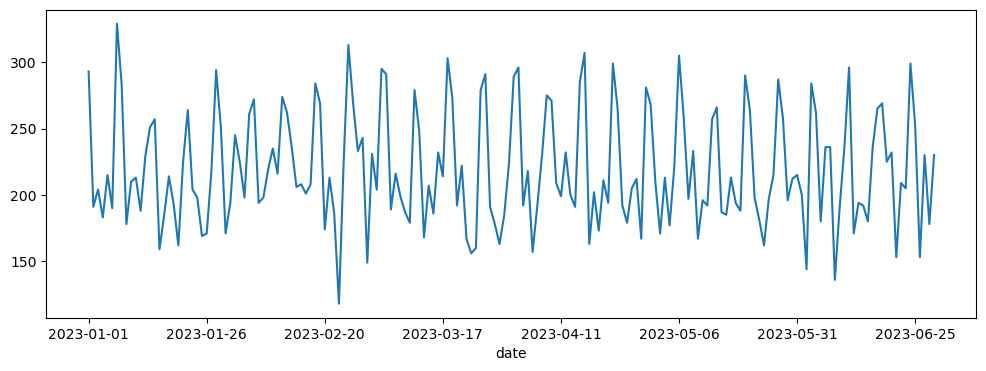

In [8]:
#Total Unit Sold Per Day
df.groupby('date')['units_sold'].sum().plot(figsize=(12,4))

<Axes: xlabel='date'>

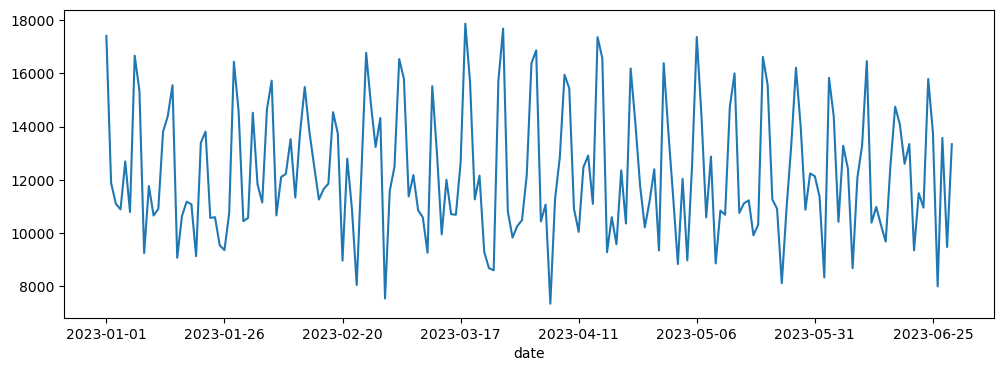

In [9]:
#Total Revenue Over Time
df['revenue']=df['price']*df['units_sold']
df.groupby('date')['revenue'].sum().plot(figsize=(12,4))

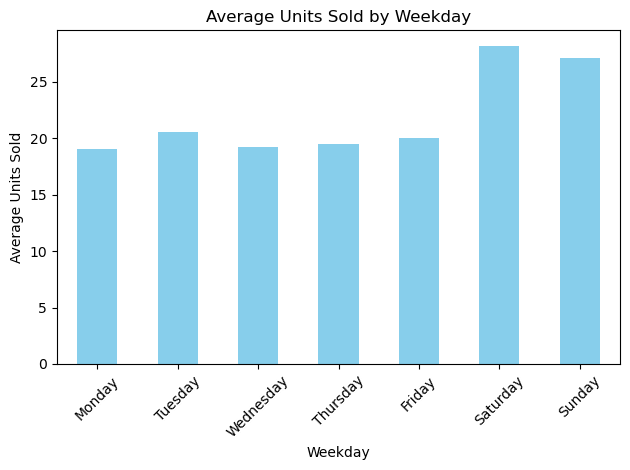

In [10]:
#seasonality/weekday Trends
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['weekday'] = df['date'].dt.day_name()

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('weekday')['units_sold'].mean().reindex(weekday_order).plot(kind='bar', color='skyblue')
plt.title('Average Units Sold by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Average Units Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



<Axes: xlabel='price', ylabel='units_sold'>

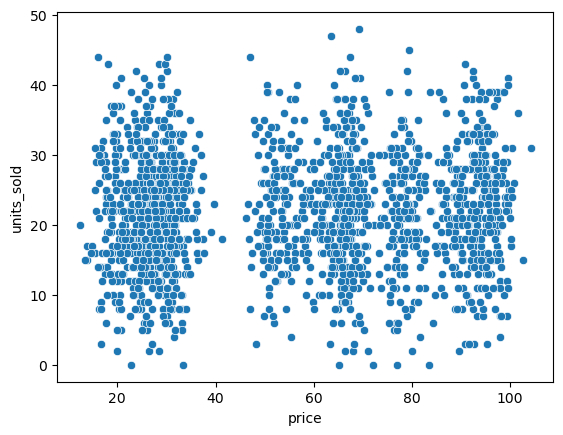

In [11]:
#price vs unitsold(DEMAND CURVE)
sns.scatterplot(data=df,x='price',y='units_sold')

<Axes: xlabel='price_diff', ylabel='units_sold'>

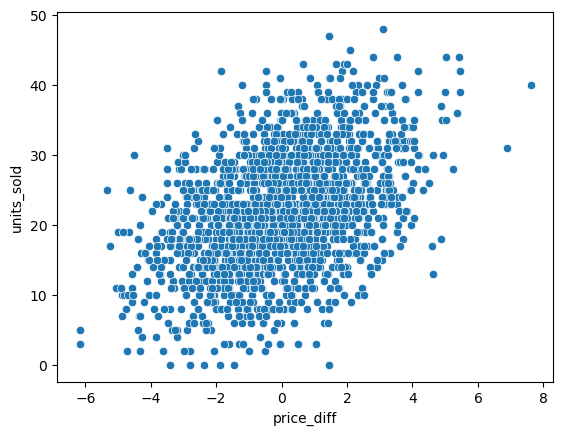

In [12]:
df['price_diff']=df['competitor_price']-df['price']
sns.scatterplot(data=df,x='price_diff',y='units_sold')

<Axes: ylabel='category'>

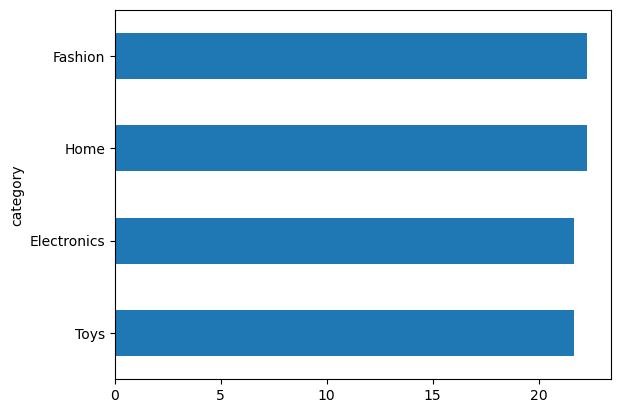

In [13]:
#Category-wise Analysis
df.groupby('category')['units_sold'].mean().sort_values().plot(kind='barh')


<Axes: xlabel='is_holiday'>

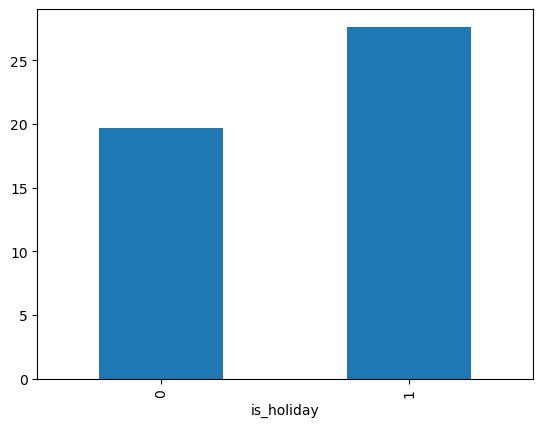

In [14]:
#holiday Impact
df.groupby('is_holiday')['units_sold'].mean().plot(kind='bar')


<Axes: xlabel='log_price', ylabel='log_demand'>

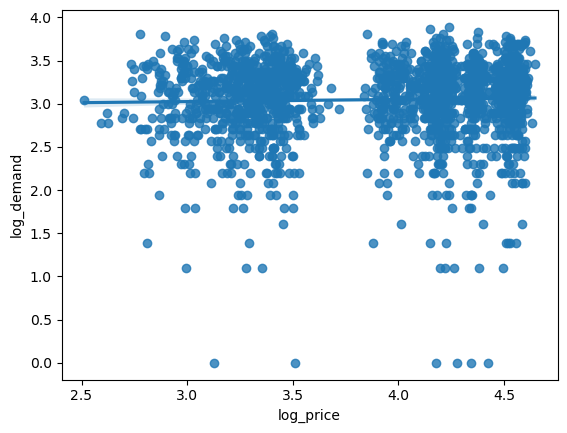

In [15]:
#Price Elasticity
df['log_price'] = np.log(df['price'])
df['log_demand'] = np.log(df['units_sold'] + 1) 
sns.regplot(x='log_price', y='log_demand', data=df)


In [16]:
#Feature Engg 

In [17]:
df['price_diff'] = df['competitor_price'] - df['price']
df['discount'] = df['price_diff'] / df['competitor_price']
df['revenue'] = df['price'] * df['units_sold']


In [18]:
#Time Based Features
df['dayofweek'] = df['date'].dt.dayofweek  # 0=Monday, 6=Sunday
df['month'] = df['date'].dt.month
df['weekend'] = df['dayofweek'].isin([5, 6]).astype(int)


In [19]:
#Rolling Features 
df = df.sort_values(['product_id', 'date'])
df['rolling_avg_units_7d'] = df.groupby('product_id')['units_sold'].transform(lambda x: x.shift(1).rolling(7).mean())


In [20]:
#Traffic and Inventory 
df['inventory_ratio'] = df['inventory'] / df.groupby('product_id')['inventory'].transform('max')


In [21]:
df = pd.get_dummies(df, columns=['category'], drop_first=True)


In [22]:
df.dropna(inplace=True)


In [23]:
features = [
    'price', 'competitor_price', 'price_diff', 'discount', 'page_views', 
    'inventory', 'inventory_ratio', 'is_holiday', 'dayofweek', 'month', 'weekend',
    'rolling_avg_units_7d'
] + [col for col in df.columns if col.startswith('category_')]


Demand Prediction Modeling

In [25]:
from sklearn.model_selection import train_test_split

# Select features
feature_cols = [
    'price', 'competitor_price', 'price_diff', 'discount', 'page_views', 
    'inventory', 'inventory_ratio', 'is_holiday', 'dayofweek', 'month', 'weekend',
    'rolling_avg_units_7d'
] + [col for col in df.columns if col.startswith('category_')]

X = df[feature_cols]
y = df['units_sold']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [27]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

model = XGBRegressor(n_estimators=100, max_depth=4, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


ModuleNotFoundError: No module named 'xgboost'

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


In [29]:
#Evaluate Model
from sklearn.metrics import r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 4.34
RMSE: 5.57
R² Score: 0.51


C:\Users\saran\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


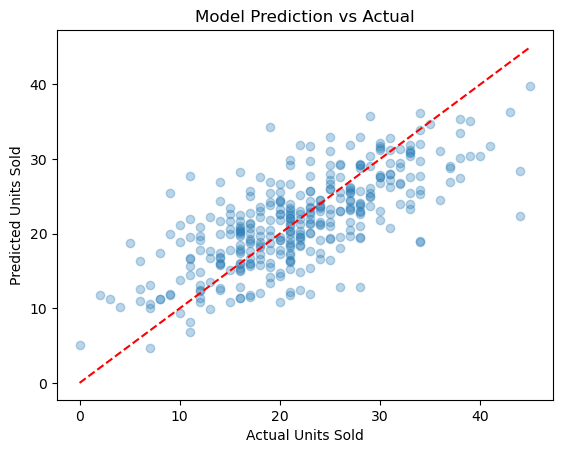

In [30]:


plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Units Sold")
plt.ylabel("Predicted Units Sold")
plt.title("Model Prediction vs Actual")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()


<Axes: title={'center': 'Feature Importance'}>

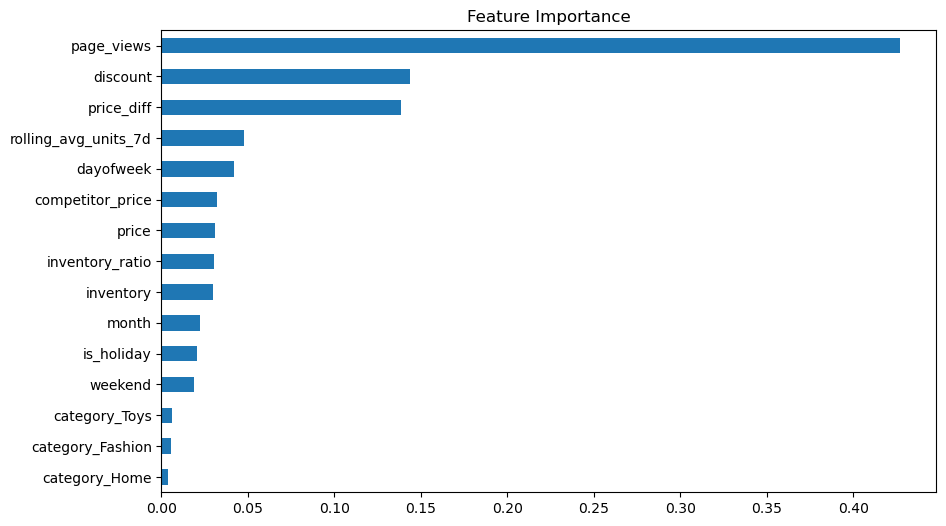

In [31]:
#Feature Importance
feature_imp = pd.Series(model.feature_importances_, index=X.columns)
feature_imp.sort_values(ascending=True).plot(kind='barh', figsize=(10,6), title="Feature Importance")


In [36]:
 #Dynamic Pricing Optimization Engine

In [42]:
#Simulate a range of prices

price_range = np.arange(10, 100, 2)  # Try prices from ₹10 to ₹100
simulated = pd.DataFrame({'price': price_range})


In [44]:
print(df['product_id'].unique())
print(df['date'].min(), df['date'].max())
sample = df.sample(1).copy()
for col in ['competitor_price', 'page_views', 'inventory', 'inventory_ratio',
            'is_holiday', 'dayofweek', 'month', 'weekend', 'rolling_avg_units_7d']:
    simulated[col] = sample[col].values[0]


['P0001' 'P0002' 'P0003' 'P0004' 'P0005' 'P0006' 'P0007' 'P0008' 'P0009'
 'P0010']
2023-01-08 00:00:00 2023-06-29 00:00:00


In [46]:
#Copy static features from the selected row
for col in ['competitor_price', 'page_views', 'inventory', 'inventory_ratio',
            'is_holiday', 'dayofweek', 'month', 'weekend', 'rolling_avg_units_7d']:
    simulated[col] = sample[col].values[0]


simulated['price_diff'] = simulated['competitor_price'] - simulated['price']
simulated['discount'] = simulated['price_diff'] / simulated['competitor_price']


In [48]:
for col in [c for c in df.columns if c.startswith('category_')]:
    simulated[col] = sample[col].values[0]


In [50]:
simulated['predicted_units_sold'] = model.predict(simulated[feature_cols])
simulated['predicted_revenue'] = simulated['price'] * simulated['predicted_units_sold']


In [52]:
best_row = simulated.loc[simulated['predicted_revenue'].idxmax()]
best_price = best_row['price']
best_revenue = best_row['predicted_revenue']

print(f"Optimal Price: ₹{best_price:.2f}")
print(f"Expected Revenue: ₹{best_revenue:.2f}")


Optimal Price: ₹88.00
Expected Revenue: ₹3043.92


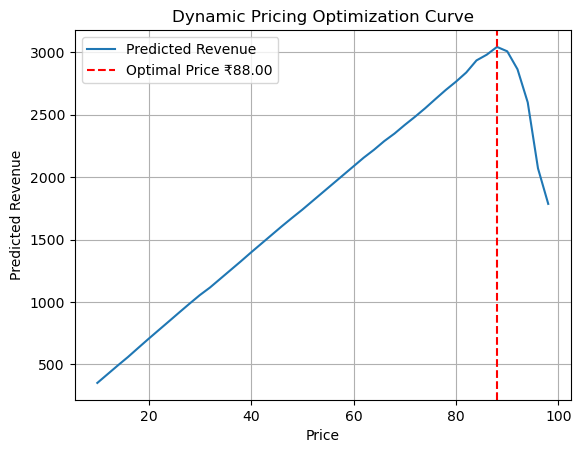

In [54]:

plt.plot(simulated['price'], simulated['predicted_revenue'], label='Predicted Revenue')
plt.axvline(best_price, color='red', linestyle='--', label=f'Optimal Price ₹{best_price:.2f}')
plt.xlabel("Price")
plt.ylabel("Predicted Revenue")
plt.title("Dynamic Pricing Optimization Curve")
plt.legend()
plt.grid(True)
plt.show()
